In [32]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model

quantiles = [0.1, 0.25, 0.75, 0.9]


x = np.linspace(0, 10, 1000)
eps = np.random.normal(0, 1, 1000)
y = eps*x + x**1.3

df = pd.DataFrame({'x': x, 'y': y})


def fit_model(quantile, model):
    res = model.fit(q=quantile)
    param_names = res.params.keys()
    # first one is intercept
    without_intercept = param_names[1:]
    ret_list = [quantile] + [res.params["Intercept"]] + [res.params[coefficient] for coefficient in without_intercept]
    for coefficient in without_intercept:
        ret_list += res.conf_int().loc[coefficient].tolist()

    return ret_list

def run_regression(df, response_var, ind_vars):
    model_string = f' {response_var}  ~ {" + ".join(ind_vars)}'
    print(model_string)
    model = smf.quantreg(f' {response_var}  ~ {" + ".join(ind_vars)}', data=df)
    models = [fit_model(x, model) for x in quantiles]
    models = pd.DataFrame(models, columns=["quantile"] + ["Intercept"] + [f"{var} Coefficient" for var in ind_vars] + [item for var in ind_vars for item in [f"{var} Lower", f"{var} Upper"]])
    return models


quantile_models = run_regression(df, response_var='y', ind_vars=['x'])
print(quantile_models)



 y  ~ x
   quantile  Intercept  x Coefficient   x Lower   x Upper
0      0.10  -1.265314       0.713983  0.614792  0.813173
1      0.25  -0.960380       1.267198  1.176522  1.357875
2      0.75  -0.576339       2.579692  2.475340  2.684045
3      0.90  -0.434178       3.162733  3.036842  3.288625


In [33]:
ols_model = linear_model.LinearRegression()
ols_model = ols_model.fit(df['x'].values.reshape(-1,1), df['y'].values.reshape(-1,1))
print(f'{ols_model.intercept_[0]} + {ols_model.coef_[0][0]}x')


-1.640878760375493 + 2.0984085342192467x


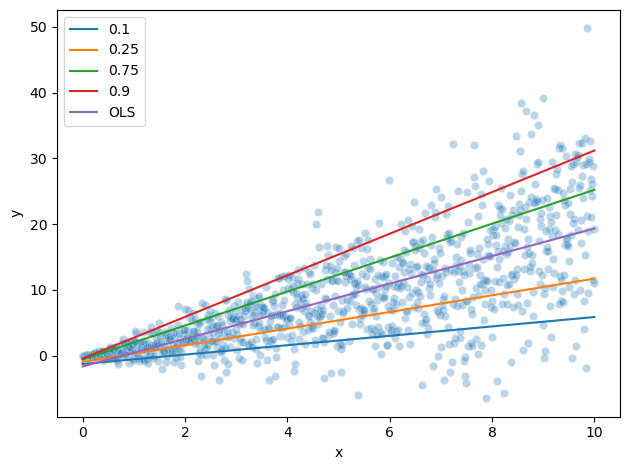

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


ax = sns.scatterplot(data=df, x='x', y='y', alpha=0.3)
for i in range(quantile_models.shape[0]):
    ax.plot(x, quantile_models.loc[i, 'Intercept'] + quantile_models.loc[i, 'x Coefficient']*x, label=f"{quantile_models.loc[i, 'quantile']}")

ax.plot(x, ols_model.intercept_[0] + ols_model.coef_[0][0] * x, label='OLS')
ax.legend()
plt.tight_layout()
plt.savefig('./quantregdemo.png')